# Predicting fuel efficiency (mpg) from car features 

Data source: https://archive.ics.uci.edu/dataset/9/auto+mpg

In [1]:
# Import my personal EDA, data cleaning and plotting packages 
from scripts.info_extractor import DataFrameInfo
from scripts.regression import RegressionTools
from scripts.plotter import Plotter

# Import libraries
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt

# Import library modules
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

## **Part I: Data cleaning and EDA**

### 1. Import and understand data set

In [2]:
cars = pd.read_csv('Data/auto-mpg.csv')
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


### Data Dictionary

- **mpg**: Target variable. Miles-per-gallon. How many miles can a car go with 1 gallon of fuel.
- **cylinder**: number of cylinders in the engine.
- **displacement**: volume of the engine. The higher the displacement, the larger the engine.
- **horsepower**: higher horspower means the car is more powerful, and likely to use more fuel on average.
- **weight**: weight of the entire vehicle in pounds.
- **acceleration**: represents how quickly a car gets to 60 mph (p.a. 100 km/h) expressed in seconds.
- **model year**: year the car model was released.
- **origin**: region the car came from: 1 - US, 2 - Europe, 3 - Japan.
- **car name**: ID column. Name of the car model.


### 2. QA and data cleaning

#### 2.1. Check and fix column datatypes

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


**Issue 1**: horsepower datatype should be numeric and has been read as object. Let's check why and then convert to numeric:


In [4]:
cars['horsepower'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

Seems to have some rows with '?' - these are missing values. When converting to numeric, they will be coerced as NaNs:

In [5]:
cars['horsepower'] = pd.to_numeric(cars['horsepower'], errors='coerce')

**Issue 2**: the column 'origin' looks like a categorical feature that has been numerically encoded. 

Let's fix this:

In [6]:
cars['origin'] = cars['origin'].astype('object')
# cars['car name'] = pd.Categorical(cars['car name'])

#### 2.2. Check for missing and inconsistent values
Are there any missing values?

In [7]:
# Let's look at the shape of the dataframe
cars.shape

## output (rows, columns)

(398, 9)

In [8]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


<Axes: >

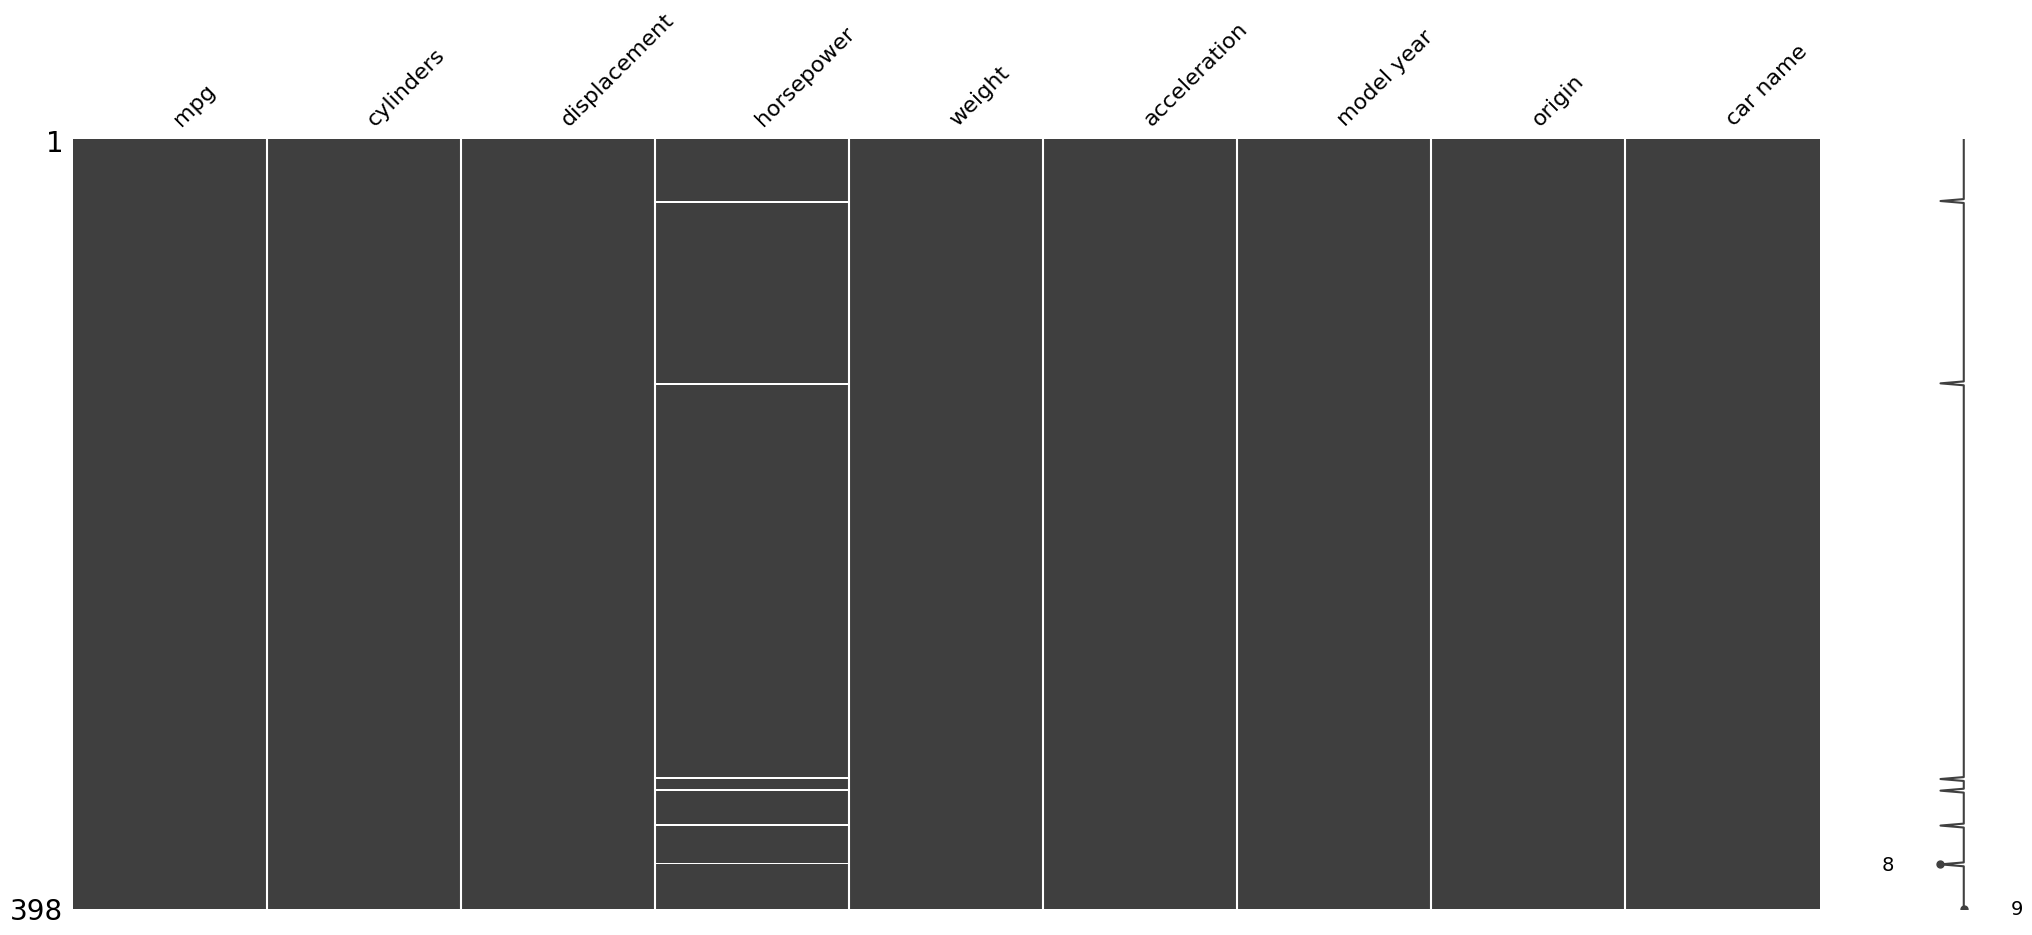

In [9]:
# Let's visualise missing values in the horsepower column
msno.matrix(cars)

In [10]:
# As there is only 6 records missing horsepower data, let's take a closer look at them
cars[cars['horsepower'].isna()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,NaN,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,1,amc concord dl


The mode of the distribution is 150.0
The mean of the distribution is 104.46938775510205
The median of the distribution is 93.5


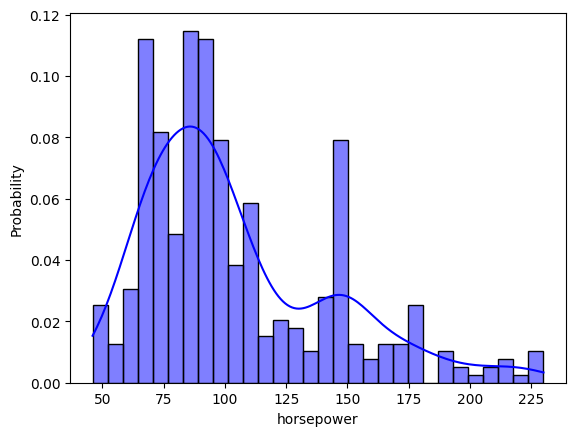

In [11]:
# Plot horsepower probability distribution
plotter = Plotter(cars) # create instance of the class

plotter.continuous_probability_distribution('horsepower')

Various options to deal with these missing values:
- Search horsepower online for each of these cars, then impute with actual values.
- Impute with the mean - given that there are only 6 records missing, this will be quite robust and will not introduce significant bias.


In [12]:
# Let's impute with the mean
cars['horsepower'] = cars['horsepower'].fillna(cars['horsepower'].mean())
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


Are there any duplicated rows?

In [13]:
# Are there any duplicates? If yes, drop them
cars.duplicated().value_counts()

# There are no duplicated rows in our dataset

False    398
Name: count, dtype: int64

Are there any typos or inconsistent values?
- Does not look like it!

In [14]:
info_extractor = DataFrameInfo(cars)  # create instance of the class

In [15]:
info_extractor.count_distinct_values()

,distinct_values_count
column,
mpg,129
cylinders,5
displacement,82
horsepower,94
weight,351
acceleration,95
model year,13
origin,3
car name,305


In [16]:
# We can assume the model year column refers to the years 1970 - 1982
# Origin is a categorical variable that has already been encoded numerically 

info_extractor.show_distinct_values(['cylinders','model year', 'origin'])

Unique values in cylinders: [3 4 5 6 8]
Unique values in model year: [70 71 72 73 74 75 76 77 78 79 80 81 82]
Unique values in origin: [1 2 3]


### 2.3. Summary statistics of numerical variables

In [17]:
cars.describe()
# All values seem reasonable

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050
std,7.815984,1.701004,104.269838,38.199187,846.841774,2.757689,3.697627
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000
50%,23.000000,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


### 2.4. Exploring the **target** variable: mpg (miles per gallon)

<Axes: xlabel='mpg', ylabel='Count'>

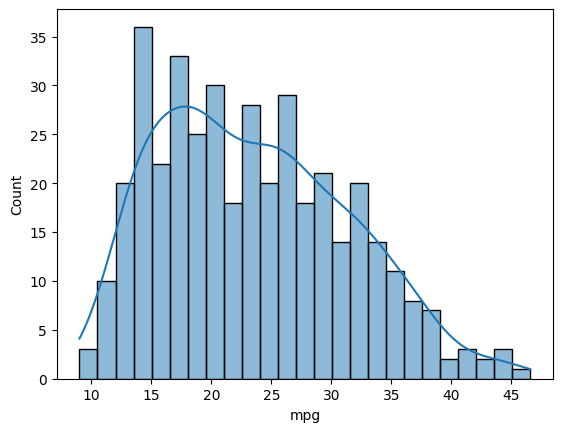

In [18]:
sns.histplot(cars['mpg'], kde=True, bins=25)

Target column is right-skewed. It still has a fairly normal shape. 
- Might need log transform - follow this up later during the modelling phase.
- Range of values is quite small.

<Axes: xlabel='mpg'>

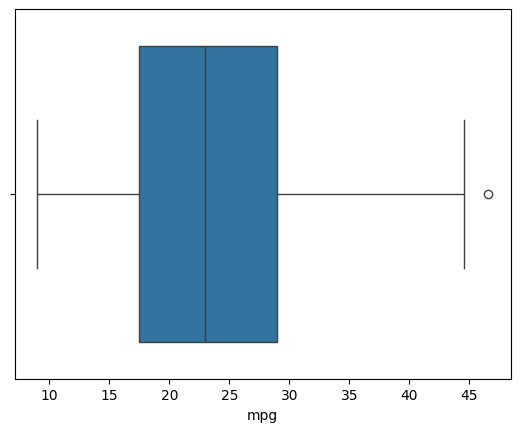

In [19]:
sns.boxplot(x=cars["mpg"])

### 2.5. Exploration: relationships between features and target (mpg)

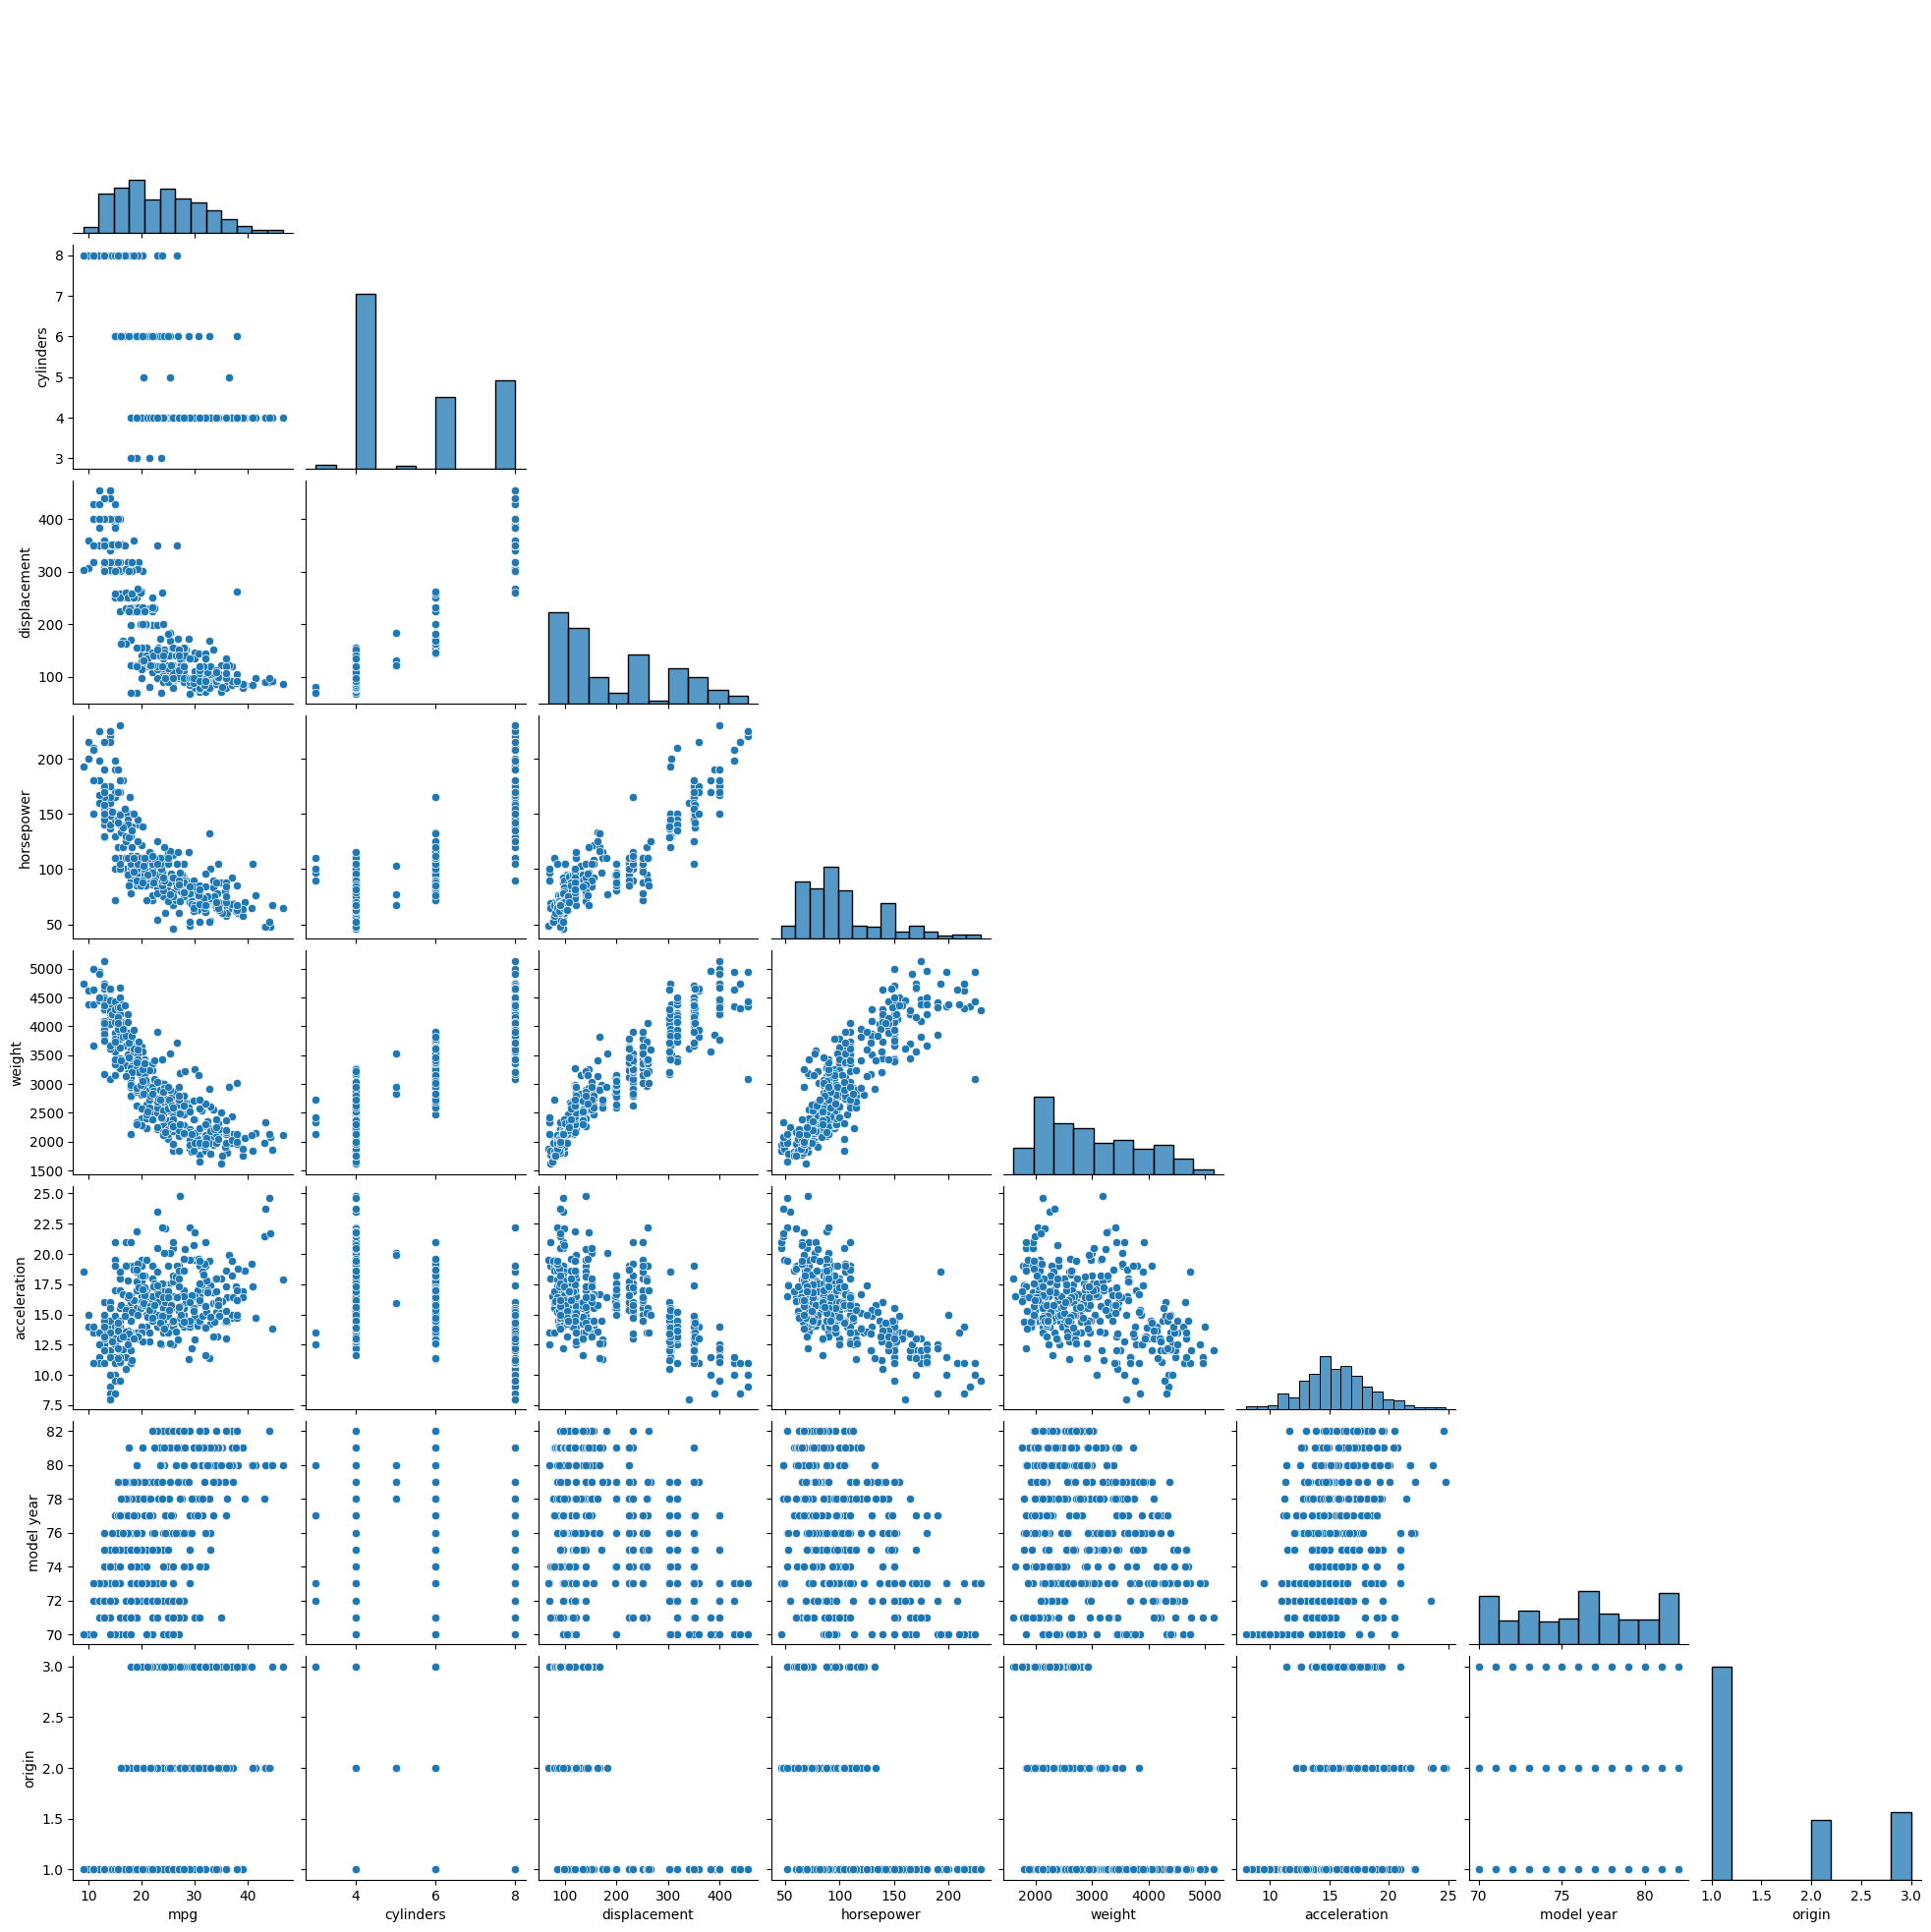

In [20]:
sns.pairplot(cars, corner=True)

##### Insights:

- Fuel economy (mpg) is negative correleated with: cylinders, displacement, horsepower and weight. As these decrease, mpg increases.
- Fuel economy (mpg) has a moderate positive correlation with model year and acceleration. The correlation with accelaration is not as strong, because given anough power, we might be able to reach this accelaration even at larger car weights.
- There is strong multicollinearity between features. As the cylinder, power, engine size and car weight decrese, accelaration increases. Lighter cars get to higher speeds more quickly.
- Model year: as time goes on, cars get more efficient on average. 
- Origin: american cars are the last fuel efficient on average, whereas european and japanese cars tend to be more efficient.

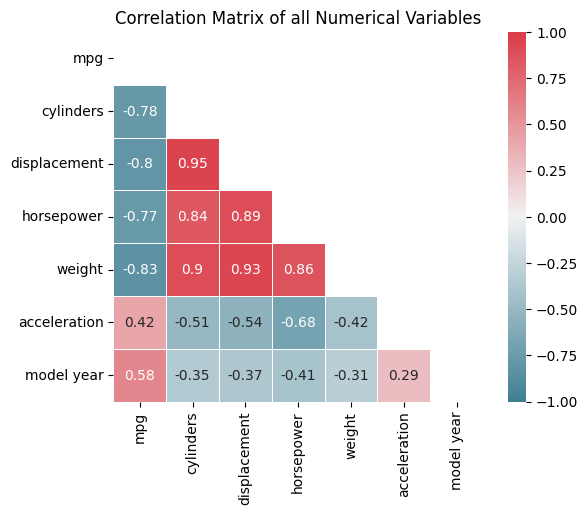

In [21]:
plotter = Plotter(cars)

plotter.correlation_matrix_df()

##### Insights: correlation coefficients

- Weight seems to be the best predictor for fuel economy (mpg) with r = -0.83.
- As time goes on cars get more efficient on average. This is a moderate positive correlation with r =  0.57.

<Axes: xlabel='origin', ylabel='mpg'>

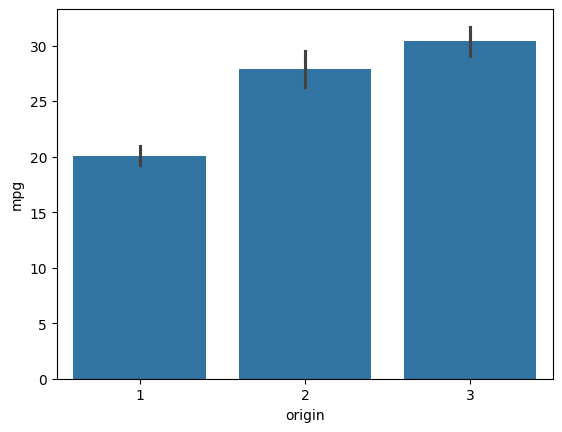

In [22]:
sns.barplot(data=cars, y='mpg', x='origin')

**HISTORICAL CONTEXT**
- During the 70s, the was a gas crisis in the US (gas prices went up). Japanese cars took a larger market share because they were more fuel efficient.
- There were also regulations in place that drove this move towards fuel efficiency during this time.

References:
- https://history.state.gov/milestones/1969-1976/oil-embargo
- https://www.history.com/news/energy-crisis-1970s-innovation

## **Part II: Building a predictive regression model**

### 1. Set up validation method: K-fold cross validation

Common standard is n_splits = 5 folds

In [23]:
# We are using cross-validation method included in RegressionTools class (personal scripts)

### 2. Build baseline model: simple linear regression (weight & mpg)

#### 2.1. Split data

Split: 80% training - 20% testing data

In [24]:
target = 'mpg'
features = ['weight'] # main predictor - for baseline model

X = sm.add_constant(cars[features]) # Splitting for baseline model

y = cars[target]

# Test Split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=3045)

In [25]:
# create first instance of class
regression = RegressionTools()

#### 2.1. Fit the model

In [26]:
first_model = regression.cross_validation_OLS(X, y, n_splits=5)

All Training R2s: [0.684, 0.684, 0.702, 0.681, 0.706]
Training R2s: 0.691 +- 0.01
Training MAEs: [3.498, 3.455, 3.449, 3.483, 3.29]
Training MAEs: 3.435 +- 0.075
All Validation R2s: [0.71, 0.718, 0.624, 0.726, 0.629]
Cross Val R2s: 0.681 +- 0.045
All Validation MAEs: [3.196, 3.306, 3.6, 3.203, 3.969]
Cross Val MAEs: 3.455 +- 0.296


- Validation R2s are a bit unstable - there's quite a lot of variation

- mpg range = 9 - 46. Validation MAE is good, considering the mpg range

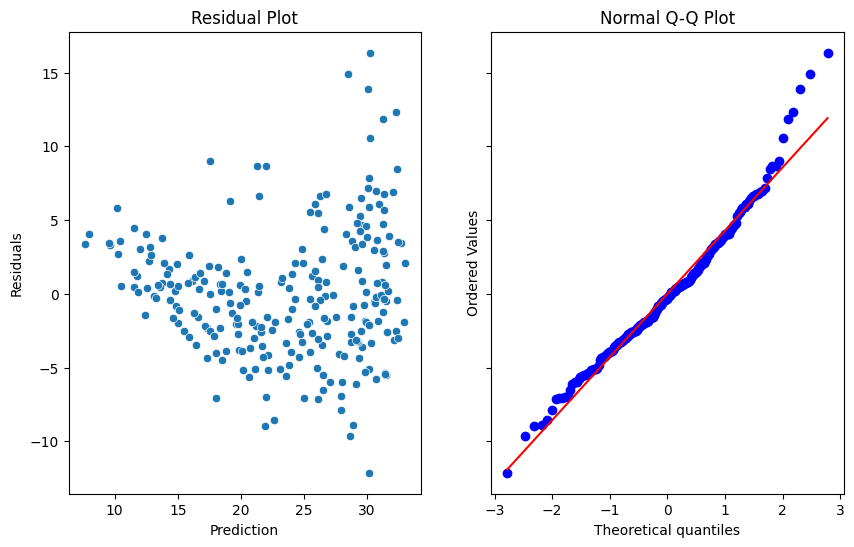

In [27]:
regression.residual_analysis_plots(first_model)

#### First baseline model - Checking assumptions

1. Linearity - there is some curvature in the mpg - weight relationship. Perhaps needs a squared factor?
2. Independence or errors - not tested yet
3. Normality - Slighly off, will check again later after model tuning
4. No Perfect Multicollinearity - not applicable with only one feature
5. Equal Variance of errors - slight heteroskedasticity (conical shape) seen in the residual plot. Likely due to lack of linearity. Check again after model tuning

### 3. Model tuning: Multiple Linear Regression model 

#### 3.1. Feature selection and feature engineering 

In [28]:
cars_model = cars.assign(
    weight2 = cars['weight'] ** 2   # Add new features to the model
).drop(['car name'], axis=1)    # Drop ID/label column

cars_model = pd.get_dummies(cars_model, drop_first=True, dtype=int)

In [29]:
cars_model.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,weight2,origin_2,origin_3
0,18.0,8,307.0,130.0,3504,12.0,70,12278016,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,13638249,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,11806096,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,11785489,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,11895601,0,0


### 3.2. Split the data

Split: 80% training - 20% testing data 

In [30]:
target = 'mpg'

features = ['weight', 
            'weight2',
            'origin_2',
            'origin_3',   # Even though this is not significant, we are looking at all origin variables as a group, so keep
            'model year'
            ] 

# drop_cols = ['cylinders', 'displacement', 'horsepower', 'acceleration', 'origin_3']

X = sm.add_constant(cars_model[features])
# X = sm.add_constant(cars_model.drop([target] + drop_cols, axis=1))

y = cars_model[target]

# Test Split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=3045)

In [31]:
# create second instance of RegressionTools class, using newly created X and y
regression_tuned = RegressionTools()

In [32]:
model = regression.cross_validation_OLS(X, y, n_splits=5)

All Training R2s: [0.855, 0.855, 0.863, 0.854, 0.86]
Training R2s: 0.857 +- 0.003
Training MAEs: [2.259, 2.221, 2.193, 2.249, 2.168]
Training MAEs: 2.218 +- 0.034
All Validation R2s: [0.856, 0.852, 0.808, 0.863, 0.838]
Cross Val R2s: 0.843 +- 0.019
All Validation MAEs: [2.175, 2.223, 2.406, 2.168, 2.42]
Cross Val MAEs: 2.278 +- 0.111


#### 3.3. Checking and fixing model assumptions

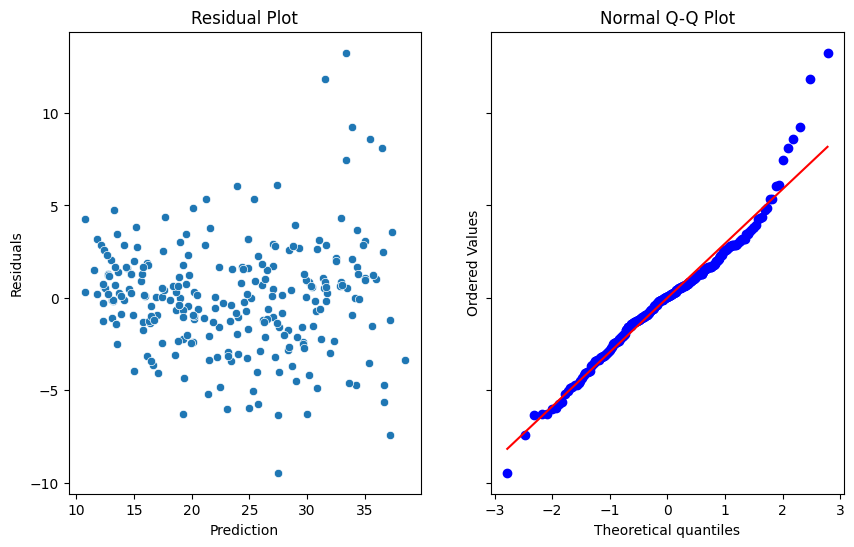

In [33]:
regression_tuned.residual_analysis_plots(model)

In [34]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     304.9
Date:                Wed, 12 Jun 2024   Prob (F-statistic):          6.05e-104
Time:                        11:16:06   Log-Likelihood:                -639.58
No. Observations:                 255   AIC:                             1291.
Df Residuals:                     249   BIC:                             1312.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1949      5.086      0.432      0.666      -7.823      12.213
weight        -0.0214      0.002    -11.276      0.000      -0.025      -0.018
weight2      2.34e-06   2.89e-07      8.082      0.000    1.77e-06    2.91e-06
origin_2       1.1221      0.595      1.887      0.060      -0.049       2.294
origin_3       0.4462      0.609      0.733      0.464      -0.753       1.645
model year     0.8170      0.057     14.448      0.000       0.706       0.928
==============================================================================
Omnibus:                       30.798   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.708
Skew:                           0.536   Prob(JB):                     8.11e-18
Kurtosis:                       5.502   Cond. No.                     2.98e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Checking multicollinearity issues with VIF

In [35]:
regression_tuned.VIF(X)

const         741.306516
weight         71.075835
weight2        67.734048
origin_2        1.412558
origin_3        1.618275
model year      1.161021
dtype: float64

Looking for influential points (outliers) using Cook's distance

In [36]:
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df["cooks_d"].sort_values(ascending=False).head()

322    0.079107
326    0.078328
111    0.055784
394    0.052143
244    0.048333
Name: cooks_d, dtype: float64

No significant outliers/influential points - Cook's Distance < 0.5 for all.

#### Checking model assumptions

1. Linearity - no obvious curvature
2. Independence - DW Test Statistic looks good. Close to ideal DW = 2. (Needs to be between 1.5 - 2.5)
3. Normality - Slighly off before adding weight^2 term, much better afterwards. May affect interpretability though.
4. No Perfect MultiCollinearity - VIFs look good. All lower than 5 except for related variables.
5. Equal Variance of errors - slight heteroskedasticity in baseline model, now much better in final model. There are a few outliers in the residual plot, but for the most part they look constant across predictions

### 4. Final model fit and scoring on test data 

Before we evaluate the model on the test data, let's fit it on all 5 folds (beofre, we were fitting on 4 folds and evaluating on the 5th)

In [37]:
final_model = sm.OLS(y, X).fit()

final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     372.7
Date:                Wed, 12 Jun 2024   Prob (F-statistic):          3.16e-129
Time:                        11:16:06   Log-Likelihood:                -805.24
No. Observations:                 318   AIC:                             1622.
Df Residuals:                     312   BIC:                             1645.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5083      4.692     -0.321      0.748     -10.741       7.725
weight        -0.0214      0.002    -12.469      0.000      -0.025      -0.018
weight2     2.362e-06    2.6e-07      9.071      0.000    1.85e-06    2.87e-06
origin_2       1.2284      0.538      2.284      0.023       0.170       2.286
origin_3       0.6810      0.550      1.238      0.217      -0.401       1.763
model year     0.8650      0.051     16.932      0.000       0.765       0.966
==============================================================================
Omnibus:                       39.304   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.018
Skew:                           0.631   Prob(JB):                     1.27e-19
Kurtosis:                       5.231   Cond. No.                     2.98e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our model looks pretty robust

#### **Scoring on Test Data: R2 and MAE**

Finally, let's evaluate the model on the test data (20% split for the beginning)

In [38]:
print(f"Test MAE: {mae(y_test, final_model.predict(X_test))}") 
print(f"Test R2: {r2(y_test, final_model.predict(X_test))}")

Test MAE: 2.112528103103629
Test R2: 0.8409314730663001


We have an error of 2.1 mpg in terms of predicted fuel efficiency

### **Model interpretation and insights**

- **Model year**: year to year, mileage (mpg) increases by 0.87 mpg.

## **Next steps**

1. Look into regularised models - e.g. Ridge regression